# MCRL for article

In [39]:
import numpy as np
import random
import math 
from collections import defaultdict

In [40]:
z = 10 #Degradation threshold

def state(amount):
    new_state = []    
    if (amount >= 0 and amount <2):
        new_state = 0 # healthy1
    
    if (amount >= 2 and amount <7):
        new_state = 1 # healthy2
        
    if (amount >= 7 and amount < z ):
        new_state = 2 #healthy3 
        
    if (amount >= z):
        new_state = 3 # fail
    
    return new_state

In [41]:
def Rewardfun(degradation):
    Reward=np.zeros((4,)+(3,))
    Reward[: , 0] = -50
    Reward[3,0] = -1050
    Reward[: , 1] = -500*(degradation/z)-50
    Reward[3,1] = -1150
    Reward[: , 2] = -550
    Reward[3,2] = -1550
       
    return Reward

In [42]:
def possible_action(state):
    if state == 0 :
        return [0,1]
    if state == 1 :
        return [0,1,2]
    if state == 2:
        return [0,1,2]
    if state == 3:
        return [2]

In [43]:
possible_action(3)

[2]

In [70]:
a = 8

def Envirenment(degradation , action):
   
    n2 = np.random.poisson((1-0.001)*4, 1) # number of effective shock
    w2 = np.random.gamma(0.6, 1.2, n2) # magnitude of effective shock
    magnitude = sum(w2)
    next_state = 0
    reward = 0
    
    if action == 0 :#do nothing
        
            degradation += (magnitude + 3)/a
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
        
    if action == 1 : #repair
        
           # decay = degradation*np.random.beta(0.5, 1, 1)
            #decay = degradation/z
            #degradation -= decay*degradation
            degradation = np.max((0.05, degradation))
            decay =(np.random.gamma(degradation*degradation/2,2/(degradation),1)/z)[0]
            degradation -= np.max((0, decay*degradation))
            degradation = np.max((0.05, degradation))
            degradation += (magnitude + 2.95)/a
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
                    
    if action == 2 : # replace
        
            degradation = (magnitude + 2.85)/a
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
       
    
    return next_state , reward , degradation


In [79]:
Envirenment(6.929383290900782 , 1)

(0, -147.53000894663182, 1.9506001789326366)

# pi function 

In [45]:
def policy_using_pi(state, pi):
    return np.random.choice(possible_action(state), p=[pi[(state,a)] for a in possible_action(state)])

In [46]:
#np.zeros((4,3))
#np.array([[0.5,0.5,0],[0.33,0.34,0.33],[0.33,0.33,0.34],[0,0,1]])
pi = np.array([[0.7,0.3,0],[0.34,0.33,0.33],[0.33,0.34,0.33],[0,0,1]])

In [47]:
policy_using_pi(0, pi)

0

In [48]:
def choose_action(current_state, pi):
    return policy_using_pi(current_state, pi)  #epsilon_soft       

# Episode Function

In [49]:
GAMMA =  0.9
def play_episode(pi):
    #S0,A0,R1,S1,A1,R2,S2,A2,R3 ,...
    s = 0 #it is new
    d = 0 #it is new
    a= choose_action(s, pi)
    
    #r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
    states_actions_rewards = [((s, a, 0))]
    
    for j in range(200 +1):
    
        s , r ,d  = Envirenment(d,a)
        if (j == 200):
            states_actions_rewards.append((s, None, r))
        else:
            a= choose_action(s, pi)
            states_actions_rewards.append((s,a, r))
            
    
     # calculate the returns by working backwards from the terminal state
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        
       # the value of the terminal state is 0 by definition
       # we should ignore the first state we encounter
        # and ignore the last G, which is meaningless since it doesn't correspond to any move
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + GAMMA*G
    
    return states_actions_returns 


In [50]:
GAMMA =  0.9
def play_episode_F(pi):
    #S0,A0,R1,S1,A1,R2,S2,A2,R3 ,...
    s = 0 #it is new
    d = 0 #it is new
    a= choose_action(s, pi)
    
    #r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
    states_actions_rewards = [((s, a, 0))]
    
    while not s == 3:
    
        s , r ,d  = Envirenment(d,a)
        if (s == 3):
            states_actions_rewards.append((s, None, r))
        else:
            a= choose_action(s, pi)
            states_actions_rewards.append((s,a, r))
            
    
     # calculate the returns by working backwards from the terminal state
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        
       # the value of the terminal state is 0 by definition
       # we should ignore the first state we encounter
        # and ignore the last G, which is meaningless since it doesn't correspond to any move
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + GAMMA*G
    
    return states_actions_returns 


In [51]:
#pi = np.array([[0.99,0.01,0],[0.34,0.33,0.33],[0.33,0.34,0.33],[0,0,1]])
#play_episode_F(pi)

In [52]:
#print(np.full((4,3), 0.5)) 
#print(np.zeros((4, ) + (3,)))

# Run all episodes

In [53]:
epsilon = 1
learning_rate = 1
pi = np.array([[0.99,0.01,0],[0.34,0.33,0.33],[0.33,0.34,0.33],[0,0,1]])
Q = np.zeros((4, ) + (3,))
old_Q = 0 

Q[3,0]= -100000000
Q[3,1]= -100000000
Q[0,2]= -100000000

returns =np.zeros((4,) + (3,))
N = np.zeros((4 ,) + (3,))

deltas = []


for epi in range(900 +1):# Looping through episodes 
    
    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_episode(pi)
    
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
    
        state_action = (s,a)
        
        if state_action not in seen_state_action_pairs:
            
            returns[s][a] += G
            N[s][a] +=1
            old_Q = Q[s][a]    
            Q[s][a] = returns[s][a] /N[s][a] # Average reward across episodes
            
            biggest_change = max(biggest_change, np.abs(old_Q - Q[s][a]))
            seen_state_action_pairs.add(state_action)
              
            #for each s in the episode         
            A_star = np.argmax(Q[s])# Finding the action with maximum value 
            
            for a in possible_action(s): # Update action probability 
                if a == A_star:
                    pi[(s,a)] = 1 - epsilon + (epsilon / len(possible_action(s)))
                else:
                    pi[(s,a)] = (epsilon / len(possible_action(s)))
                     
    
    learning_rate *= 0.99
    epsilon *= 0.99               
    deltas.append(biggest_change)
                  

C:\Users\ARYA\AppData\Local\Temp\ipykernel_1788\6110552.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  degradation += (magnitude + 3)/a
C:\Users\ARYA\AppData\Local\Temp\ipykernel_1788\6110552.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  degradation = (magnitude + 2.85)/a
C:\Users\ARYA\AppData\Local\Temp\ipykernel_1788\6110552.py:34: RuntimeWarning: divide by zero encountered in true_divide
  degradation = (magnitude + 2.85)/a


In [54]:
print (Q)
print(pi)

[[-5.34699577e+03 -5.87854661e+03 -1.00000000e+08]
 [-1.17543988e+03 -4.61048720e+03 -4.52816320e+03]
 [-5.34527466e+03 -1.92191800e+03 -4.88799750e+03]
 [-1.00000000e+08 -1.00000000e+08 -1.13787914e+03]]
[[9.99941028e-01 5.89719029e-05 0.00000000e+00]
 [9.99921371e-01 3.93146020e-05 3.93146020e-05]
 [3.93146020e-05 9.99921371e-01 3.93146020e-05]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


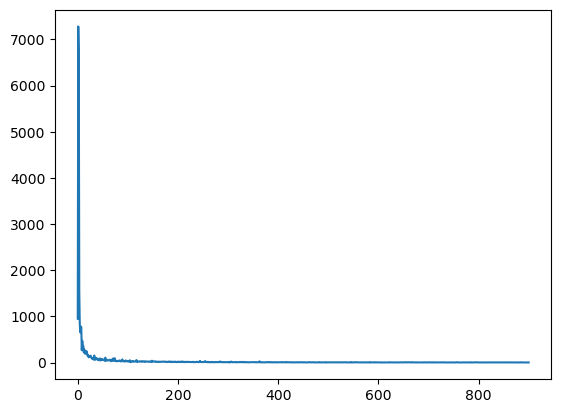

In [55]:
import matplotlib.pyplot as plt
plt.plot(deltas)
plt.show()

In [81]:
a = 8

def Envirenment(degradation , action):
   
    n2 = np.random.poisson((1-0.001)*4, 1) # number of effective shock
    w2 = np.random.gamma(0.6, 1.2, n2) # magnitude of effective shock
    magnitude = sum(w2)
    next_state = 0
    reward = 0
    
    if action == 0 :#do nothing
        
            degradation += (magnitude + 3)/a
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
        
    if action == 1 : #repair
        
           # decay = degradation*np.random.beta(0.5, 1, 1)
            #decay = degradation/z
            #degradation -= decay*degradation
            degradation = np.max((0.05, degradation))
            decay =(np.random.gamma(degradation*degradation/2,2/(degradation),1)/z)[0]
            degradation -= np.max((0, decay*degradation))
            degradation = np.max((0.05, degradation))
            degradation += (magnitude + 2.95)/a
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
                    
    if action == 2 : # replace
        
            degradation = (magnitude + 2.85)/a
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
       
    
    return next_state , reward , degradation


In [82]:
optimal_value =[]
current_state = 0 #it is new
degradation = 0
optimal_cost = []
expected_optimal_cost=[]
num=[]
numm =[]

        
for j in range(20+1):
    #Choose A from S
    action = np.argmax(Q[current_state])
    if action == 1:
        optimal_value.append(degradation) 
        num.append(j)
    
    numm =[3*num[i] - 3*num[i-1] for i in range(1, len(num))]
    #print(num , numm)
    # Take action
    current_state, reward ,degradation_new = Envirenment(degradation,action)
    optimal_cost.append(-reward)
    print ("degradation =" + str(degradation), "action"+ str(action),
          "Reward"+str(reward), "new degradation =" + str(degradation_new))
    degradation = degradation_new
    #print(optimal_cost)
    #if any(np.array(optimal_cost) > 50) and any(np.array(optimal_cost) < 550) :
        #expected_optimal_cost.append(np.mean(optimal_cost))
    if any(np.array(optimal_cost) > 50):
        expected_optimal_cost.append(np.mean(optimal_cost))
    if action ==1:
        optimal_cost = []
    
    
#print(optimal_value)
#print(".................")
#print(expected_optimal_cost)
#print(".................")
print("optimal degradation for repair=",np.mean(optimal_value))
#print(".................")
print("cost for repair =",np.mean(expected_optimal_cost))
print("Time for repair =",np.mean(numm))
#print("Time for repair =",numm)

degradation =0 action0 Reward-50.0 new degradation =1.4837546956997056
degradation =1.4837546956997056 action0 Reward-50.0 new degradation =2.1616965382246747
degradation =2.1616965382246747 action0 Reward-50.0 new degradation =2.6351009960200407
degradation =2.6351009960200407 action0 Reward-50.0 new degradation =3.3606036540892648
degradation =3.3606036540892648 action0 Reward-50.0 new degradation =4.304430130618588
degradation =4.304430130618588 action0 Reward-50.0 new degradation =5.07622573755917
degradation =5.07622573755917 action0 Reward-50.0 new degradation =6.245629101685738
degradation =6.245629101685738 action0 Reward-50.0 new degradation =6.720801886607862
degradation =6.720801886607862 action0 Reward-50.0 new degradation =7.145086602316304
degradation =7.145086602316304 action1 Reward-224.24134172129467 new degradation =3.4848268344258937
degradation =3.4848268344258937 action0 Reward-50.0 new degradation =4.078019130345132
degradation =4.078019130345132 action0 Reward-50